In [1]:
import pandas as pd
import numpy as np
import rasterio
import math
import geopandas as gpd
from shapely.geometry import Point
from fiona import Env
import matplotlib.pyplot as plt
from rasterio.mask import mask


In [2]:
# Function to convert latitude and longitude to Bing Maps Quadkey
def lat_lon_to_quadkey(lat, lon, level):
    tile_size = 256

    # Clip latitude and longitude to max values
    lat = max(min(lat, 85.0511287798), -85.0511287798)
    lon = max(min(lon, 180), -180)

    # Convert latitude and longitude to pixel coordinates in a level zoom of the Earth
    x = (lon + 180) / 360
    sin_lat = math.sin(lat * math.pi / 180)
    y = 0.5 - math.log((1 + sin_lat) / (1 - sin_lat)) / (4 * math.pi)

    # Convert Earth coordinates to pixel coordinates
    map_size = tile_size << level
    pixel_x = int(clip(x * map_size + 0.5, 0, map_size - 1))
    pixel_y = int(clip(y * map_size + 0.5, 0, map_size - 1))

    # Convert pixel coordinates to tile coordinates
    tile_x = int(math.floor(pixel_x / tile_size))
    tile_y = int(math.floor(pixel_y / tile_size))

    # Convert tile coordinates to a quadkey
    quadkey = ""
    for i in range(level, 0, -1):
        digit = 0
        mask = 1 << (i - 1)
        if (tile_x & mask) != 0:
            digit += 1
        if (tile_y & mask) != 0:
            digit += 2
        quadkey += str(digit)

    return quadkey

# Function to clip a number to the specified minimum and maximum values
def clip(n, min_value, max_value):
    return min(max(n, min_value), max_value)

# Test the function with an example coordinate
test_quadkey = lat_lon_to_quadkey(45.0, -122.0, 14)
test_quadkey


'02123201001313'

In [3]:
rwi_df = pd.read_csv('/Users/kismatkhatri/Documents/Capstone project/RWI.csv')
rwi_df['quadkey'] = rwi_df.apply(lambda row: lat_lon_to_quadkey(row['latitude'], row['longitude'], 14), axis=1)

In [4]:
# Assuming rwi_df is your DataFrame and the 'quadkey' column has been added
#rwi_df.to_csv('/Users/kismatkhatri/Documents/Capstone project/RWI_with_quadkey.csv', index=False)


In [5]:

rwi_df.head()

,latitude,longitude,rwi,error,quadkey
0,33.897776,70.037842,-0.074,0.624,12310221130231
1,31.118794,66.807861,-0.569,0.368,12303111302200
2,32.648625,73.245850,-0.193,0.498,12310322022121
3,35.182788,72.894287,-0.178,0.355,12310213112323
4,25.948166,69.268799,-0.530,0.450,12312201232000


In [6]:
# import rasterio
# from pyquadkey2.quadkey import QuadKey

# # Function to get the raster values for a quadkey from a TIFF file
# def get_population_data_from_quadkey(tiff_path, quadkey_str):
#     qk = QuadKey(quadkey_str)
#     bbox = qk.to_bbox()

#     with rasterio.open(tiff_path) as src:
#         # Translate the bounding box into pixel coordinates
#         py, px = src.index(bbox.min_lng, bbox.max_lat)
#         qy, qx = src.index(bbox.max_lng, bbox.min_lat)
        
#         # Make sure we don't have negative pixel indices
#         px, py, qx, qy = max(px, 0), max(py, 0), max(qx, 0), max(qy, 0)
        
#         # Read the pixel values in the window
#         window = rasterio.windows.Window(px, py, qx-px, qy-py)
#         data = src.read(1, window=window)
        
#         return data

# # Paths to your TIFF files
# tiff_paths = ['/Users/kismatkhatri/Documents/Capstone project/population_20_lon_60_general-v1.5.tif', 
#               '/Users/kismatkhatri/Documents/Capstone project/population_20_lon_70_general-v1.5.tif', 
#               '/Users/kismatkhatri/Documents/Capstone project/population_30_lon_60_general-v1.5.tif',
#              '/Users/kismatkhatri/Documents/Capstone project/population_30_lon_70_general-v1.5.tif' ]



# # Iterate over the RWI data to extract population data for each quadkey
# for index, observation in rwi_df.iterrows():
#     quadkey_str = observation['quadkey']
    
#     # You need logic here to determine which TIFF file the quadkey corresponds to
#     # This could involve checking the extents of the quadkey against the extents of the TIFF files
#     # For this example, we will assume it's the first TIFF file
#     tiff_path = tiff_paths[0]
    
#     population_data = get_population_data_from_quadkey(tiff_path, quadkey_str)
#     # Now you can process the population data as needed


AttributeError: 'QuadKey' object has no attribute 'to_bbox'

In [8]:

# Load the raster data
with rasterio.open('/Users/kismatkhatri/Downloads/pak_pd_2020_1km.tif') as src:
    pop_data = src.read(1)  # Read the first band
    # Create a mask for valid data (assuming no data values are represented as such)
    mask = pop_data > 0  # Replace with the appropriate condition for valid data
    rows, cols = np.where(mask)
    coords = [src.xy(row, col) for row, col in zip(rows, cols)]  # Convert indices to coordinates
    
    # Convert the coordinates to quadkeys
    quadkeys = [lat_lon_to_quadkey(lat, lon, 14) for lon, lat in coords]
    population = pop_data[mask]  # Extract population values for valid data points
    
    # Create a DataFrame from the quadkeys and population
    pop_quadkey_df = pd.DataFrame({'quadkey': quadkeys, 'population': population})

# Aggregate the population by quadkeys to get the sum of the population per level 14 tile
pop_quadkey_agg_df = pop_quadkey_df.groupby('quadkey')['population'].sum().reset_index()

# Load RWI data and add quadkeys
rwi_df = pd.read_csv('/Users/kismatkhatri/Documents/Capstone project/RWI.csv')
rwi_df['quadkey'] = rwi_df.apply(lambda row: lat_lon_to_quadkey(row['latitude'], row['longitude'], 14), axis=1)

# Join the aggregated population data with the RWI data based on the quadkey
rwi_pop_joined_df = pd.merge(rwi_df, pop_quadkey_agg_df, on='quadkey', how='left')

# Check for any mismatched quadkeys
unmatched_quadkeys = rwi_pop_joined_df[rwi_pop_joined_df['population'].isnull()]['quadkey'].unique()
if len(unmatched_quadkeys) > 0:
    print(f"Warning: There are {len(unmatched_quadkeys)} quadkeys without matching population data.")

# Save the joined DataFrame to a new CSV file
rwi_pop_joined_df.to_csv('/Users/kismatkhatri/Documents/Capstone project/joined_RWI_population.csv', index=False)

# Check the first few rows to ensure the population has been joined correctly
print(rwi_pop_joined_df.head())


    latitude  longitude    rwi  error         quadkey   population
0  33.897776  70.037842 -0.074  0.624  12310221130231  3119.037109
1  31.118794  66.807861 -0.569  0.368  12303111302200  1192.453247
2  32.648625  73.245850 -0.193  0.498  12310322022121  4926.342285
3  35.182788  72.894287 -0.178  0.355  12310213112323  1739.792480
4  25.948166  69.268799 -0.530  0.450  12312201232000  1315.402466


In [10]:
Pslm_data = pd.read_stata('/Users/kismatkhatri/Documents/Capstone project/310_PSLM201920_Rescaledbyhhsize_160654obs.dta')

In [11]:
variables_list1 = [
    "W_dkw_inspiped",
    "W_dkw_inshandpump",
    "W_dkw_insmotorpump",
    "W_dkw_insclosedwell",
    "W_dkw_insopenwell",
    "W_dkw_insprotsprng",
    "W_dkw_insunprsprng",
    "W_dkw_outpiped",
    "W_dkw_outhandpump",
    "W_dkw_outmotorpump",
    "W_dkw_outclosedwell",
    "W_dkw_outopenwell",
    "W_dkw_outprotsprng",
    "W_dkw_outunprsprng",
    "W_dkw_pond",
    "W_dkw_bottwater",
    "W_dkw_tanker",
    "W_dkw_filtration",
    "W_dkw_other",
    "W_toilet_notoilet",
    "W_toilet_flushpub",
    "W_toilet_flushtank",
    "W_toilet_flushpit",
    "W_toilet_flushopen",
    "W_toilet_raiselat",
    "W_toilet_pitlat",
    "W_toilet_other",
    "W_toiletshared",
    "W_toiletprivate",
    "H_cooking_firewood",
    "H_cooking_gas",
    "H_cooking_lpg",
    "H_cooking_dung",
    "H_cooking_crop",
    "H_cooking_other",
    "H_floor_earth",
    "H_floor_ceramic",
    "H_floor_cement",
    "H_floor_bricks",
    "H_floor_other",
    "H_roof_rccrbc",
    "H_roof_wood",
    "H_roof_sheet",
    "H_roof_grader",
    "H_roof_other",
    "H_walls_burntbricks",
    "H_walls_mudbricks",
    "H_walls_wood",
    "H_walls_stones",
    "H_walls_other",
    "D_iradio",
    "D_itelevsion",
    "D_ilcdled",
    "D_irefrigerator",
    "D_ifreezer",
    "D_iwashing",
    "D_idryer",
    "D_iairconditioning",
    "D_iaircooler",
    "D_ifan",
    "D_istove",
    "D_icookingrange",
    "D_imicrowave",
    "D_isewingmachine",
    "D_iknitting",
    "D_iiron",
    "D_iwaterfilter",
    "D_idonkeypump",
    "D_iturbine",
    "D_ichair",
    "D_itable",
    "D_iups",
    "D_igenerator",
    "D_isolarpanel",
    "D_iheater",
    "D_igeaser",
    "D_ibicycle",
    "D_imotorcyclescotter",
    "D_irichshaw",
    "D_icar",
    "D_ivantruckbus",
    "D_iboat",
    "D_itractortralloy",
    "D_iclock"
]

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Assuming Pslm_data and variables_list1 are defined and imported correctly.

# Step 1: Extract the selected columns and drop rows with missing values
selected_variables = Pslm_data[variables_list1].dropna().reset_index(drop=True)

# Step 2: Perform Min-Max scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(selected_variables)

# Step 3: Calculate the square root of weights and adjust the scaled data
weights = Pslm_data.loc[selected_variables.index, 'popwt']
sqrt_weights = np.sqrt(weights)

# This ensures that the weights are applied to each observation
weighted_data = scaled_data * sqrt_weights[:, None]  # Using None instead of np.newaxis to avoid the warning

# Step 4: Apply PCA on the weighted data
pca = PCA(n_components=1)
pca.fit(weighted_data)

# Multiply the PCA components by the square root of the eigenvalues if necessary
components = pca.transform(weighted_data) * np.sqrt(pca.explained_variance_)

# Step 5: Analyze the PCA output
explained_variance = pca.explained_variance_ratio_[0]
print(f'PCA variance explained: {explained_variance * 100:.2f}%')

# Create the basis vector DataFrame
basis_vector = pd.DataFrame(pca.components_.T, index=variables_list1, columns=['Magnitude'])

# Sort the basis vector by magnitude in descending order
basis_vector.sort_values(by='Magnitude', ascending=False, inplace=True)

# Normalize the wealth index if necessary to match the expected range
wealth_index = components.squeeze()
min_max_scaler = MinMaxScaler(feature_range=(-2, 2))
Pslm_data['Wealth_Index1'] = min_max_scaler.fit_transform(wealth_index.reshape(-1, 1))

# Save the basis vector and updated DataFrame to CSV files
basis_vector.to_csv('PSLM_DATA_with_basis_vector.csv')
Pslm_data.to_csv('PSLM_data_with_wealth_index.csv', index=False)


/var/folders/zg/n2c3c7jj1t5dv6zbxjqxzbnc0000gn/T/ipykernel_16559/3052149695.py:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  weighted_data = scaled_data * sqrt_weights[:, None]  # Using None instead of np.newaxis to avoid the warning


PCA variance explained: 25.60%


In [46]:

# Load and aggregate PSLM data by district
pslm_data = pd.read_csv("PSLM_data_with_wealth_index.csv")
pslm_district_wealth = pslm_data.groupby('District').agg({
    'Wealth_Index1': 'mean',
    'popwt': 'sum'
}).reset_index()

# # Load the joined RWI data with population information
# rwi_data = pd.read_csv("/Users/kismatkhatri/Documents/Capstone project/joined_RWI_population.csv")

# # Load districts shapefile with environment settings to restore .shx index files
# with Env(SHAPE_RESTORE_SHX='YES'):
#     districts = gpd.read_file('/Users/kismatkhatri/Documents/Capstone project/shapefile/pak_admbnda_adm2_wfp_20220909.shp')

# # Convert RWI data into GeoDataFrame
# geometry = [Point(xy) for xy in zip(rwi_data['longitude'], rwi_data['latitude'])]
# rwi_data = gpd.GeoDataFrame(rwi_data, geometry=geometry)

# # Ensure CRS match
# rwi_data.crs = districts.crs

# # Perform the spatial join to associate RWI data with districts
# rwi_data_with_district = gpd.sjoin(rwi_data, districts, how="left", op="within")

# # Filter RWI data by specified provinces
# provinces_to_include = ["Punjab", "Sindh", "Balochistan", "Khyber Pakhtunkhwa", "Islamabad"]
# filtered_rwi_district_data = rwi_data_with_district[rwi_data_with_district['ADM1_EN'].isin(provinces_to_include)]

# # Aggregate RWI data by district, now including the population
# filtered_rwi_district_data = filtered_rwi_district_data.groupby('ADM2_EN').agg({'rwi': 'mean', 'population': 'sum'}).reset_index()







In [43]:
# Create a mapping dictionary for district names
district_mapping = {
    'Central Karachi': 'Karachi Central',
    'Chitral Lower': 'Chitral',
    'Chitral Upper': 'Chitral',
    'D. I. Khan': 'Dera Ismail Khan',
    'East Karachi': 'Karachi East',
    'Kashmore': 'Kashmor',
    'Kohistan Lower': 'Kohistan',
    'Kohistan Upper': 'Kohistan',
    'Korangi Karachi': 'Korangi',
    'Leiah': 'Layyah',
    'Malakand': 'Malakand Protected Area',
    'Malir Karachi': 'Malir',
    'Shaheed Benazir Abad': 'Shaheed Benazirabad',
    'South Karachi': 'Karachi South',
    'Tor Ghar': 'Torghar',
    'West Karachi': 'Karachi West',
    'Shaheed Sikandarabad': 'Surab'
}

# # Apply the mapping dictionary to the 'ADM2_EN' column of the filtered_rwi_district_data dataframe
# filtered_rwi_district_data['ADM2_EN'] = filtered_rwi_district_data['ADM2_EN'].replace(district_mapping)


In [48]:
# Load the joined RWI data with population information
rwi_data = pd.read_csv("/Users/kismatkhatri/Documents/Capstone project/joined_RWI_population.csv")

# Load districts shapefile with environment settings to restore .shx index files
with Env(SHAPE_RESTORE_SHX='YES'):
    districts = gpd.read_file('/Users/kismatkhatri/Documents/Capstone project/shapefile/pak_admbnda_adm2_wfp_20220909.shp')

# Convert RWI data into GeoDataFrame
geometry = [Point(xy) for xy in zip(rwi_data['longitude'], rwi_data['latitude'])]
rwi_data = gpd.GeoDataFrame(rwi_data, geometry=geometry)

# Ensure CRS match
rwi_data.crs = districts.crs

# Perform the spatial join to associate RWI data with districts
rwi_data_with_district = gpd.sjoin(rwi_data, districts, how="left", op="within")

# Filter RWI data by specified provinces
provinces_to_include = ["Punjab", "Sindh", "Balochistan", "Khyber Pakhtunkhwa", "Islamabad"]
filtered_rwi_district_data = rwi_data_with_district[rwi_data_with_district['ADM1_EN'].isin(provinces_to_include)]

# Apply the mapping dictionary to the 'ADM2_EN' column of the filtered_rwi_district_data dataframe
filtered_rwi_district_data['ADM2_EN'] = filtered_rwi_district_data['ADM2_EN'].replace(district_mapping)


# Display column names in filtered_rwi_district_data
column_names_filtered_rwi = filtered_rwi_district_data.columns
print("Column Names in filtered_rwi_district_data:")
print(column_names_filtered_rwi)


/Users/kismatkhatri/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Column Names in filtered_rwi_district_data:
Index(['latitude', 'longitude', 'rwi', 'error', 'quadkey', 'population',
       'geometry', 'index_right', 'Shape_Leng', 'Shape_Area', 'ADM2_EN',
       'ADM2_PCODE', 'ADM2_REF', 'ADM2ALT1EN', 'ADM2ALT2EN', 'ADM1_EN',
       'ADM1_PCODE', 'ADM0_EN', 'ADM0_PCODE', 'date', 'validOn', 'validTo'],
      dtype='object')


/Users/kismatkhatri/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [49]:
# Aggregate RWI data by district, now including all variables
agg_dict = {
    'rwi': 'mean',
    'population': 'sum',
    
}

filtered_rwi_district_data_agg = filtered_rwi_district_data.groupby('ADM2_EN').agg(agg_dict).reset_index()

In [61]:
# Sort districts by wealth index from PSLM and RWI
pslm_sorted = pslm_district_wealth.sort_values('Wealth_Index1').reset_index(drop=True)
rwi_sorted = filtered_rwi_district_data_agg.sort_values('rwi').reset_index(drop=True)

population_threshold = 0.14 * rwi_sorted ['population'].sum()  

# Initialize targeted districts lists
targeted_districts_pslm = []
targeted_districts_rwi = []

# Initialize population counters
population_counter_pslm = 0
population_counter_rwi = 0

# Target districts until the population threshold is reached for RWI
for index, row in rwi_sorted.iterrows():
    if population_counter_rwi + row['population'] <= population_threshold:
        targeted_districts_rwi.append(row['ADM2_EN'])
        population_counter_rwi += row['population']
    else:
        break

# Target districts until the population threshold is reached for PSLM, using 'popwt' as the population proxy
for index, row in pslm_sorted.iterrows():
    if population_counter_pslm + row['popwt'] <= population_threshold:
        targeted_districts_pslm.append(row['District'])
        population_counter_pslm += row['popwt']
    else:
        break

# Calculate performance metrics
true_positives = set(targeted_districts_pslm).intersection(set(targeted_districts_rwi))
precision = len(true_positives) / len(targeted_districts_rwi) if targeted_districts_rwi else 0
recall = len(true_positives) / len(targeted_districts_pslm) if targeted_districts_pslm else 0

# Output the performance
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Precision: 0.63
Recall: 0.60


In [62]:

# Calculate the set of all districts
all_districts = set(pslm_data['District'])

# Calculate inclusion and exclusion errors
incorrectly_included = set(targeted_districts_rwi) - set(targeted_districts_pslm)
incorrectly_excluded = set(targeted_districts_pslm) - set(targeted_districts_rwi)

# Error rates
inclusion_error = len(incorrectly_included) / len(all_districts)
exclusion_error = len(incorrectly_excluded) / len(all_districts)

# Print out the errors
print(f"Inclusion Error: {inclusion_error:.2f}")
print(f"Exclusion Error: {exclusion_error:.2f}")


Inclusion Error: 0.13
Exclusion Error: 0.15


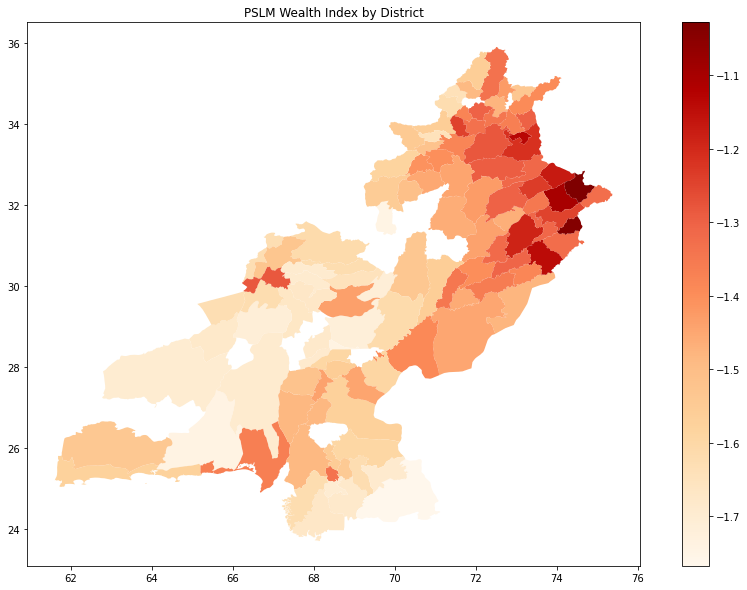

In [63]:
# Merge PSLM data with the shapefile
pslm_geo = districts.merge(pslm_district_wealth, left_on='ADM2_EN', right_on='District', how='left')

# Visualize the PSLM data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
pslm_geo.plot(column='Wealth_Index1', ax=ax, legend=True, cmap='OrRd')
plt.title('PSLM Wealth Index by District')
plt.show()

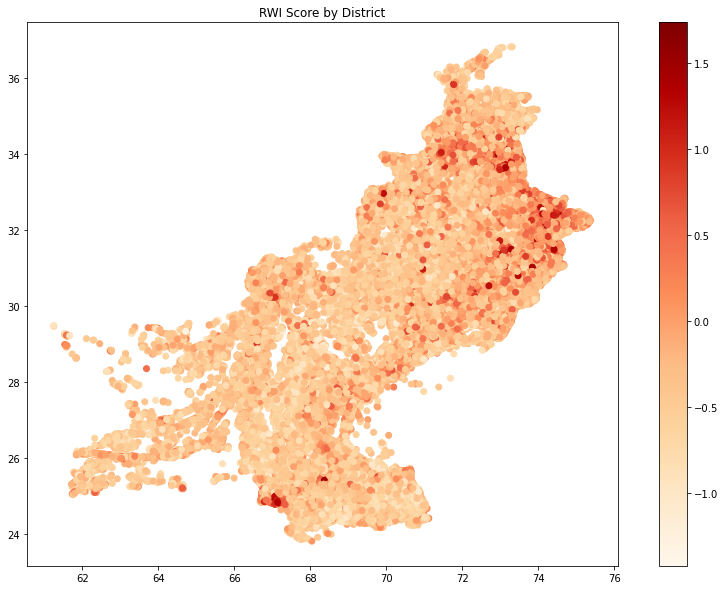

In [64]:
# For RWI data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
filtered_rwi_district_data.plot(column='rwi', ax=ax, legend=True, cmap='OrRd')
plt.title('RWI Score by District')
plt.show()

In [20]:

# rwi_data = pd.read_csv('/Users/kismatkhatri/Documents/Capstone project/RWI_with_quadkey.csv')


# def get_population_density(lon, lat, tiff_paths):
#     """
#     Extracts the population density for a given longitude and latitude from the appropriate TIFF file.
    
#     :param lon: Longitude of the point.
#     :param lat: Latitude of the point.
#     :param tiff_paths: List of paths to the TIFF files.
#     :return: Population density at the given point, or None if the point is not within any TIFF bounds.
#     """
#     # Create a Point geometry
#     point = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[Point(lon, lat)])
    
#     # Check each TIFF file
#     for tiff_path in tiff_paths:
#         with rasterio.open(tiff_path) as src:
#             # Check if the point is within the bounds of this TIFF
#             if src.bounds[0] <= lon <= src.bounds[2] and src.bounds[1] <= lat <= src.bounds[3]:
#                 # If so, extract the population density
#                 out_image, out_transform = mask(src, point.geometry, crop=True)
#                 # Return the first value (assuming single-band TIFF)
#                 return out_image[0].mean()
    
#     # Return None if the point is not in any TIFF file
#     return None
# # Paths to the TIFF files
# tiff_files = [
#     '/Users/kismatkhatri/Documents/Capstone project/PK/population_30_lon_60_general-v1.5.tif',
#     '/Users/kismatkhatri/Documents/Capstone project/PK/population_30_lon_70_general-v1.5.tif',
#     '/Users/kismatkhatri/Documents/Capstone project/PK/population_20_lon_60_general-v1.5.tif',
#     '/Users/kismatkhatri/Documents/Capstone project/PK/population_20_lon_70_general-v1.5.tif'
# ]

# # Apply the function to each row in the RWI data
# rwi_data['population_density'] = rwi_data.apply(lambda row: get_population_density(row['longitude'], row['latitude'], tiff_files), axis=1)



In [ ]:
#!pip install --upgrade pyquadkey2


In [21]:
# import pandas as pd
# from pyquadkey2.quadkey import QuadKey

# # Function to convert latitude and longitude to quadkey
# def convert_to_quadkey(latitude, longitude, level):
#     geo_coordinates = (latitude, longitude)
#     quadkey_obj = QuadKey.from_geo(geo_coordinates, level)
#     return quadkey_obj.key


# level_of_detail = 14  


# csv_path = '/Users/kismatkhatri/Documents/Capstone project/RWI.csv'
# rwi_df = pd.read_csv(csv_path)

# # Iterate over rows and add 'quadkey' column
# for index, row in rwi_df.iterrows():
#     latitude = row['latitude']
#     longitude = row['longitude']
#     quadkey = convert_to_quadkey(latitude, longitude, level_of_detail)
#     rwi_df.at[index, 'quadkey'] = quadkey


# print(rwi_df)


In [56]:
from sklearn.ensemble import RandomForestRegressor

# Extract relevant features and target variable
X = filtered_rwi_district_data[['latitude', 'longitude']]
y = filtered_rwi_district_data['rwi']

# Initialize the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X, y)


RandomForestRegressor(random_state=42)

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 2: Create Target Variable
# Assuming 'poverty_threshold' is the threshold for poverty (14%)
poverty_threshold = 0.14
filtered_rwi_district_data['poor'] = (filtered_rwi_district_data['rwi'] < poverty_threshold).astype(int)

# Step 3: Data Preparation
X = filtered_rwi_district_data[['latitude', 'longitude']]  # Add other relevant features
y = filtered_rwi_district_data['poor']

# Step 4: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Model Selection
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 6: Model Training
model.fit(X_train, y_train)

# Step 7: Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 8: Assess Model Performance
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Step 9: Predict X% Poorest (assuming 'X_percent' is the desired percentage)
X_target = filtered_rwi_district_data[['latitude', 'longitude']]  # Add other relevant features
filtered_rwi_district_data['predicted_poor'] = model.predict(X_target)

# Step 10: Set Probability Threshold (Optional)
# If the model outputs probabilities, you can use a threshold to classify as poor or not poor

# Step 11: Assess Model Performance on Full Dataset
overall_accuracy = accuracy_score(y, filtered_rwi_district_data['predicted_poor'])
overall_precision = precision_score(y, filtered_rwi_district_data['predicted_poor'])
overall_recall = recall_score(y, filtered_rwi_district_data['predicted_poor'])
overall_f1 = f1_score(y, filtered_rwi_district_data['predicted_poor'])

# Step 12: Fine-Tuning (if needed)

# Step 13: Deployment (if needed)


/Users/kismatkhatri/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Accuracy: 0.88
Precision: 0.91
Recall: 0.95
F1 Score: 0.93


/Users/kismatkhatri/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
